In [1]:
%load_ext autoreload
%autoreload 2

In [10]:
from MODULES.vae_model import *
from MODULES.utilities_ml import process_one_epoch
from MODULES.utilities_visualization import show_batch

# Check versions
from platform import python_version
print("python_version() ---> ", python_version())
print("torch.__version__ --> ", torch.__version__)

python_version() --->  3.8.2
torch.__version__ -->  1.6.0


In [11]:
params = load_json_as_dict("./ML_parameters.json")
vae = CompositionalVae(params)

In [12]:
# params

In [15]:
image_size = params['input_image']['size_raw_image']
b, c, w, h = 8, params['input_image']['ch_in'], image_size, image_size
imgs_in = torch.sigmoid(torch.randn(b,c,w, h))

optimizer = instantiate_optimizer(model=vae, dict_params_optimizer=params["optimizer"])

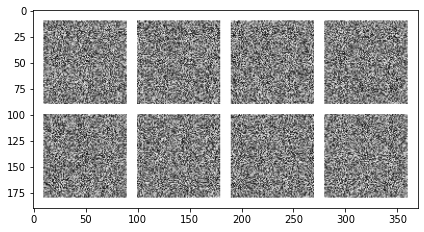

In [14]:
show_batch(imgs_in)

In [76]:
generated = vae.generate(imgs_in, draw_boxes=True)

AFTER NMS
torch.Size([25, 8])
torch.Size([25, 8])
torch.Size([8, 1, 20, 20])
torch.Size([8])
torch.Size([400, 8])
torch.Size([25, 8])


('metrics', 'inference', 'imgs')
('logit_map', 'logit_few', 'big_bg', 'big_img', 'big_mask', 'big_mask_NON_interacting', 'sample_c_map', 'sample_c', 'sample_bb', 'sample_zinstance', 'kl_logit', 'kl_zwhere', 'kl_zinstance')
torch.Size([8, 1, 20, 20])


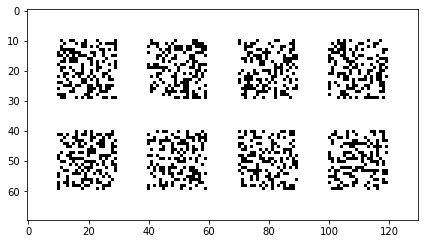

In [77]:
print(generated._fields)
print(generated.inference._fields)
print(generated.inference.sample_c_map.shape)
show_batch(generated.inference.sample_c_map.float())

Uninitialized: You must initialize neptune-client first. For more information, please visit: https://github.com/neptune-ai/neptune-client#initialize-neptune

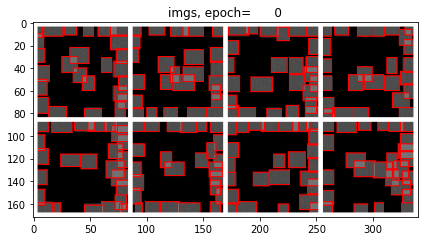

In [78]:
from MODULES.utilities_visualization import plot_reconstruction_and_inference, plot_segmentation

plot_reconstruction_and_inference(generated, epoch=0, prefix="gen_")

In [79]:
output = vae.forward(imgs_in, draw_image=True, draw_boxes=True, verbose=False)

AFTER NMS
torch.Size([25, 8])
torch.Size([25, 8])
torch.Size([8, 1, 20, 20])
torch.Size([8])
torch.Size([400, 8])
torch.Size([25, 8])


In [80]:
output.inference.sample_bb.bh[..., 0]
print(vae.inference_and_generator.size_min)
print(vae.inference_and_generator.size_max)

5
20


5
20


Uninitialized: You must initialize neptune-client first. For more information, please visit: https://github.com/neptune-ai/neptune-client#initialize-neptune

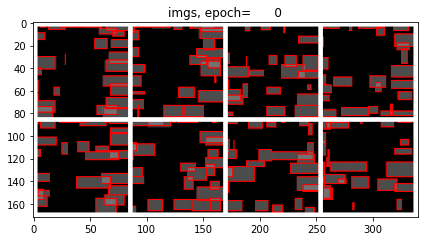

In [71]:
plot_reconstruction_and_inference(output, epoch=0, prefix="rec_")

In [69]:
vae

CompositionalVae(
  (inference_and_generator): Inference_and_Generation(
    (similarity_kernel_dpp): SimilarityKernel()
    (unet): UNet(
      (down_path): ModuleList(
        (0): DoubleConvolutionBlock(
          (double_conv): Sequential(
            (0): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
            (1): ReLU(inplace=True)
            (2): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
            (3): ReLU(inplace=True)
          )
        )
        (1): DownBlock(
          (max_pool_layer): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
          (double_conv): DoubleConvolutionBlock(
            (double_conv): Sequential(
              (0): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
              (1): ReLU(inplace=True)
              (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
              (3): ReLU(inplace=True)
            )
          )
        )
